In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns

### Prepare the dataset for training

In [2]:
df = pd.read_csv('vascular_dementia_dataset.csv')

df.describe()

,Birth Year,Sex,Education,Primary Hypertension,Secondary Hypertension,BMI Impedance,Smoking Status,Ever Smoked,Alcohol Intake Frequency,Report of stroke,...,Platelet distribution width,Red blood cell (erythrocyte) distribution width,Reticulocyte count,Blood Pressure Diastolic,Blood Pressure Systolic,Pulse Rate at Blood Pressure,Has Vascular Dementia,Heart Attack,Angina,Stroke
count,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,...,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000
mean,1943.607732,0.616843,1.619087,0.376754,0.001477,28.506288,0.648876,0.665107,2.928308,0.204383,...,16.532465,13.612258,0.064741,83.549278,148.858045,70.335019,0.477469,0.097020,0.081015,0.062300
std,4.804711,0.486216,1.057314,0.484632,0.038414,4.794312,0.648016,0.472011,1.642911,0.403300,...,0.528219,1.066313,0.030105,10.856766,19.917436,12.742064,0.499554,0.296022,0.272891,0.241729
min,1937.000000,0.000000,0.000000,0.000000,0.000000,15.757600,0.000000,0.000000,1.000000,0.000000,...,13.710000,11.490000,0.010000,47.000000,78.000000,35.000000,0.000000,0.000000,0.000000,0.000000
25%,1940.000000,0.000000,1.000000,0.000000,0.000000,25.292600,0.000000,0.000000,2.000000,0.000000,...,16.180000,13.000000,0.047000,76.000000,135.000000,61.000000,0.000000,0.000000,0.000000,0.000000
50%,1942.000000,1.000000,2.000000,0.000000,0.000000,27.797900,1.000000,1.000000,3.000000,0.000000,...,16.490000,13.430000,0.061000,83.000000,148.000000,69.000000,0.000000,0.000000,0.000000,0.000000
75%,1946.000000,1.000000,3.000000,1.000000,0.000000,31.103400,1.000000,1.000000,4.000000,0.000000,...,16.830000,14.000000,0.079000,90.000000,161.000000,78.000000,1.000000,0.000000,0.000000,0.000000
max,1965.000000,1.000000,3.000000,1.000000,1.000000,59.188300,2.000000,1.000000,6.000000,1.000000,...,19.400000,37.190000,1.077000,133.000000,241.000000,169.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
X = df.drop('Has Vascular Dementia', axis=1).values  # Features
y = df['Has Vascular Dementia'].values  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

### Define the neural network

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.sigmoid(self.layer3(x))
        return x

In [5]:
# Initialize the model
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Convert the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [6]:
# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()

    output_train = model(X_train_tensor)
    loss = criterion(output_train, y_train_tensor)

    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    predicted_train = (output_train > 0.5).float()
    train_accuracy = accuracy_score(y_train, predicted_train.numpy())

    # Evaluate on test batch
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_tensor)
        predicted_test = (output_test > 0.5).float()
        test_accuracy = accuracy_score(y_test, predicted_test.numpy())

    if (epoch + 1) % (epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [50/500], Training Loss: 0.2453, Training Accuracy: 0.9476, Test Accuracy: 0.9245
Epoch [100/500], Training Loss: 0.1160, Training Accuracy: 0.9743, Test Accuracy: 0.9336
Epoch [150/500], Training Loss: 0.0574, Training Accuracy: 0.9933, Test Accuracy: 0.9319
Epoch [200/500], Training Loss: 0.0274, Training Accuracy: 0.9996, Test Accuracy: 0.9319
Epoch [250/500], Training Loss: 0.0153, Training Accuracy: 0.9996, Test Accuracy: 0.9262
Epoch [300/500], Training Loss: 0.0102, Training Accuracy: 0.9996, Test Accuracy: 0.9204
Epoch [350/500], Training Loss: 0.0076, Training Accuracy: 0.9996, Test Accuracy: 0.9212
Epoch [400/500], Training Loss: 0.0061, Training Accuracy: 0.9996, Test Accuracy: 0.9245
Epoch [450/500], Training Loss: 0.0051, Training Accuracy: 0.9996, Test Accuracy: 0.9221
Epoch [500/500], Training Loss: 0.0045, Training Accuracy: 0.9996, Test Accuracy: 0.9237


### Evaluate the model performance

#### Model ROC-AUC curve

In [7]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

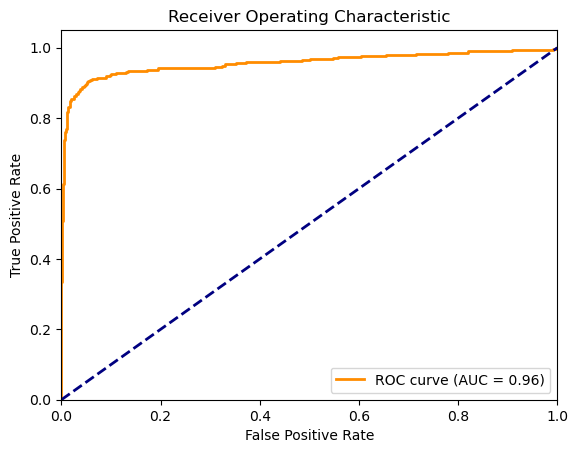

In [8]:
y_pred_prob = y_pred.numpy().flatten()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Confusion matrix

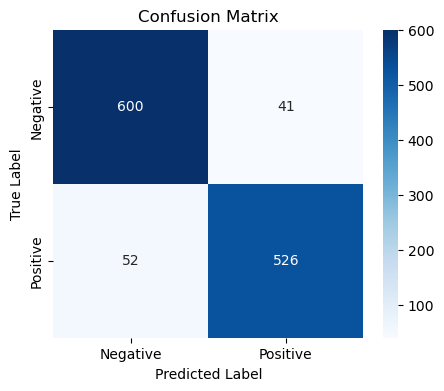

In [11]:
y_pred_labels = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Feature importance extraction using SHAPley

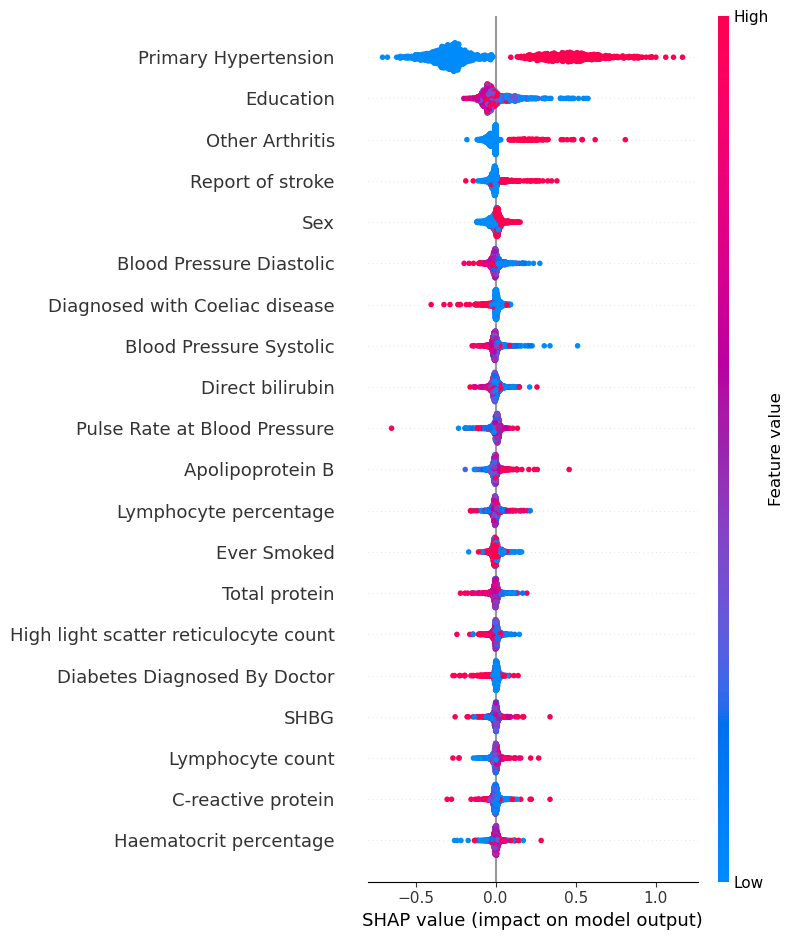

In [10]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

explainer = shap.GradientExplainer(model, X_test_tensor)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_tensor)

feature_names = df.drop(columns=["Has Vascular Dementia"]).columns.to_list()

# plot summary of feature importance
shap_values = shap_values.squeeze()  # Remove unnecessary dimensions
shap.summary_plot(shap_values, X_test, feature_names=feature_names)